<a href="https://colab.research.google.com/github/gledsoncarvalho/bigdata-analysis-copa-do-brasil/blob/main/TCC_GLEDSON_SEGUNDO_JOGO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jsonlines
!pip install enelvo
!pip install unidecode
!pip install geobr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive

drive.mount('/content/data')

Mounted at /content/data


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import re
import nltk
from textblob import TextBlob
# from spellchecker import SpellChecker
import string
# from autocorrect import Speller
from io import StringIO
import json
from pandas.io.json import json_normalize
import jsonlines
import geobr
from unidecode import unidecode

In [4]:
df = pd.DataFrame()
jogo1 = []
with jsonlines.open('/content/data/MyDrive/coleta/segundo_jogo_primeiro_tempo.jsonl', 'r') as reader:
    for obj in reader.iter(skip_invalid=True, allow_none=True):
        jogo1.append(obj)

with jsonlines.open('/content/data/MyDrive/coleta/segundo_jogo_segundo_tempo.jsonl', 'r') as reader:
    for obj in reader.iter(skip_invalid=True, allow_none=True):
        jogo1.append(obj)

In [5]:
jogo1_df = pd.DataFrame(jogo1)

In [6]:
# REMOVENDO AS COLUNAS DESNECESSÁRIAS
jogo1_df = jogo1_df.drop(columns=['attachments','conversation_id','edit_history_tweet_ids', 'lang','public_metrics', 'referenced_tweets','reply_settings', 'source', 'author', '__twarc','matching_rules', 'in_reply_to_user_id', 'in_reply_to_user'])
# jogo1_tempo2_df = jogo1_tempo2_df.drop(columns=['attachments','conversation_id','edit_history_tweet_ids', 'id', 'lang','public_metrics', 'referenced_tweets','reply_settings', 'source', 'author', '__twarc','matching_rules', 'in_reply_to_user_id', 'in_reply_to_user'])
# a.head()
jogo1_df.head()

,author_id,context_annotations,created_at,entities,geo,id,possibly_sensitive,text
0,1512496931351707667,"[{'domain': {'id': '6', 'name': 'Sports Event'...",2022-10-20T00:45:18.000Z,{},{},1582895700182208512,False,Amanhã td mnd na escola vai estar falando da h...
1,1215717125735768065,"[{'domain': {'id': '6', 'name': 'Sports Event'...",2022-10-20T00:45:18.000Z,"{'mentions': [{'start': 3, 'end': 13, 'usernam...",{},1582895699548512256,False,RT @_sccpnews: COMEÇÇÇÇAAAA OS ULTIMOS 90 MINU...
2,513721770,"[{'domain': {'id': '6', 'name': 'Sports Event'...",2022-10-20T00:45:18.000Z,{},{},1582895699833692160,False,BORA MEU CORINTHIANS
3,3475309157,"[{'domain': {'id': '6', 'name': 'Sports Event'...",2022-10-20T00:45:18.000Z,"{'annotations': [{'start': 18, 'end': 25, 'pro...",{},1582895701553737728,False,VAMOS SER CAMPEÃO FLAMENGO
4,1204512009854828544,"[{'domain': {'id': '6', 'name': 'Sports Event'...",2022-10-20T00:45:18.000Z,{},{},1582895699074908161,False,COMEÇOU VAI CORINTHIANS


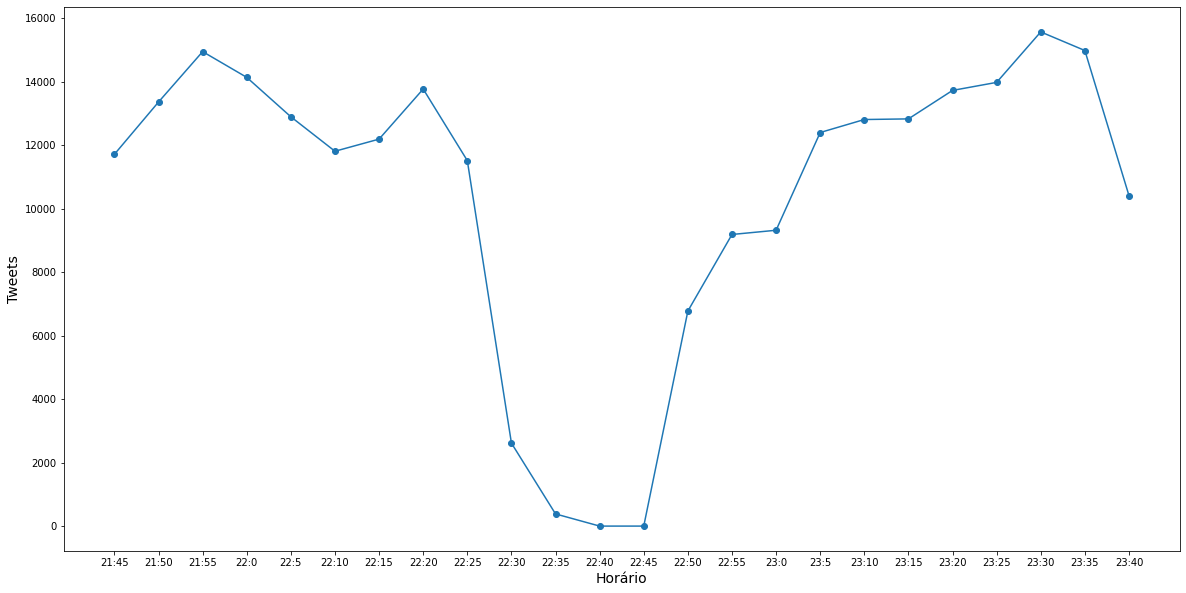

In [8]:
# PRIMEIRO TEMPO

jogo1_df = jogo1_df.sort_values(by=['created_at'])
jogo1_df["created_at"] = jogo1_df["created_at"].map(pd.Timestamp)
df = jogo1_df.groupby(pd.Grouper(key='created_at', axis=0, 
                      freq='5min')).aggregate(func='count')

x = []
pontos_x = ['21:45', '23:25']
pontos_y = [12800, 14000]
# tempo = []
for i in df.index:
    i = i.astimezone(tz='America/Sao_Paulo')
    x.append(str(i.hour) + ':' + str(i.minute))
y = df.get(['author_id'])
fig = plt.figure(figsize=(20, 10))
plt.plot(x,y, marker='o')
plt.xlabel("Horário", fontsize=14)
plt.ylabel("Tweets", fontsize=14)
plt.show()


LANCES IMPORTANTES:

1.   23:28 - gol do corinthians, giuliano
2.   23:06 - gol anulado, everton ribeiro
3.   23:03 - inacreditavel roger guedes
4.   22:58 - chance clara arrascaeta
5.   22:56 - chance clara yuri
6.   22:17 - gol anulado arrascaeta
7.   21:48 - gol do flamengo, pedro

In [3]:
# COLETA DE LOCALIDADE DOS USUÁRIOS
cidades = []
for i in jogo1_df.get('geo'):
    if (i != {}):
        # print(i)
        cidades.append(i['full_name'])

from collections import Counter
contador = Counter(cidades)

a = {}
for k,v in contador.most_common(10):
    a[k] = v

x = list(a.keys())
y = list(a.values())

fig = plt.figure(figsize=(20, 10))
plt.barh(x, y, color='maroon')
plt.xlabel("Tweets")
plt.ylabel("Cidades")
# plt.title("Cid")
plt.show()

NameError: ignored

[('CORINTHIANS', 1764), ('Pedro', 1111), ('Dorival', 775), ('roger guedes', 565), ('Arrascaeta', 311), ('Roger Guedes', 302), ('Cássio', 261), ('Gabigol', 243), ('Vidal', 235), ('Renato Augusto', 217)]


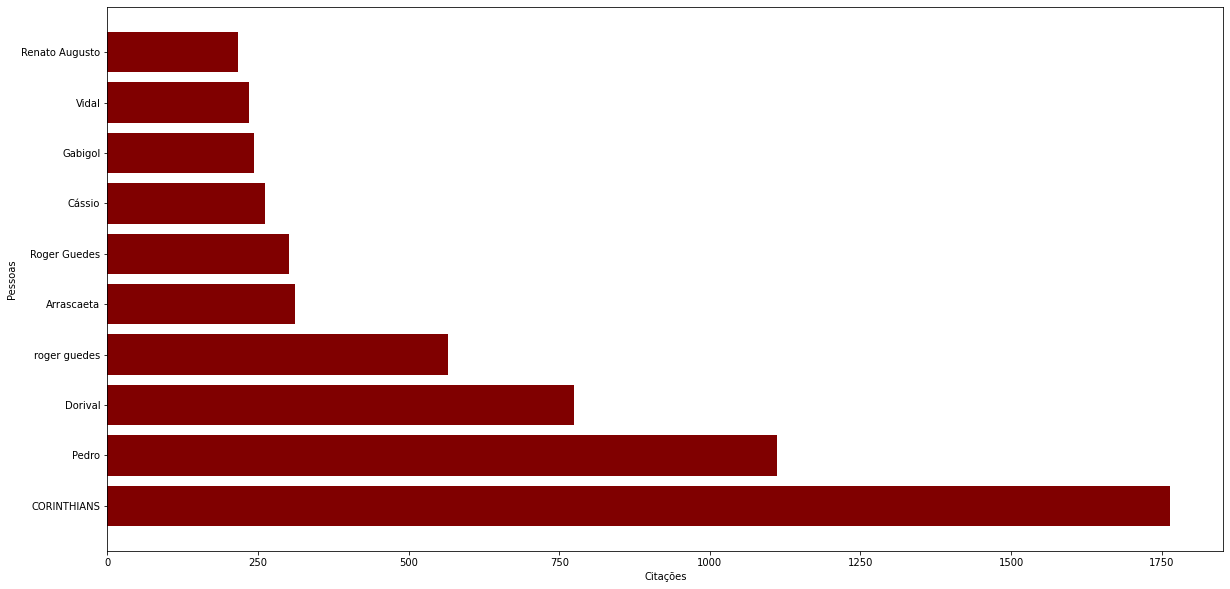

In [11]:
# PEGANDO ENTITIES - PERSON
palavras_person = []
for i in jogo1_df.get('entities'):
    if (i.get('annotations') != None):
        for j in i.get('annotations'):
            if(j.get('type') == 'Person'):
                # print(j.get('normalized_text'))
                palavras_person.append(j.get('normalized_text'))

from collections import Counter
contador = Counter(palavras_person)
# for i in contador.items():
#     print(i)
a = {}
print(contador.most_common(10))
for k,v in contador.most_common(10):
    a[k] = v

x = list(a.keys())
y = list(a.values())

fig = plt.figure(figsize=(20, 10))
plt.barh(x, y, color='maroon')
plt.xlabel("Citações")
plt.ylabel("Pessoas")
# plt.title("Cid")
plt.show()

[('Flamengo', 16593), ('Corinthians', 16516), ('flamengo', 11729), ('corinthians', 8786), ('FLAMENGO', 6775), ('FLAxCOR', 2983), ('VamosFlamengo', 1903), ('CORINTHIANS', 1502), ('colunadofla', 454), ('VAMOSFLAMENGO', 397)]


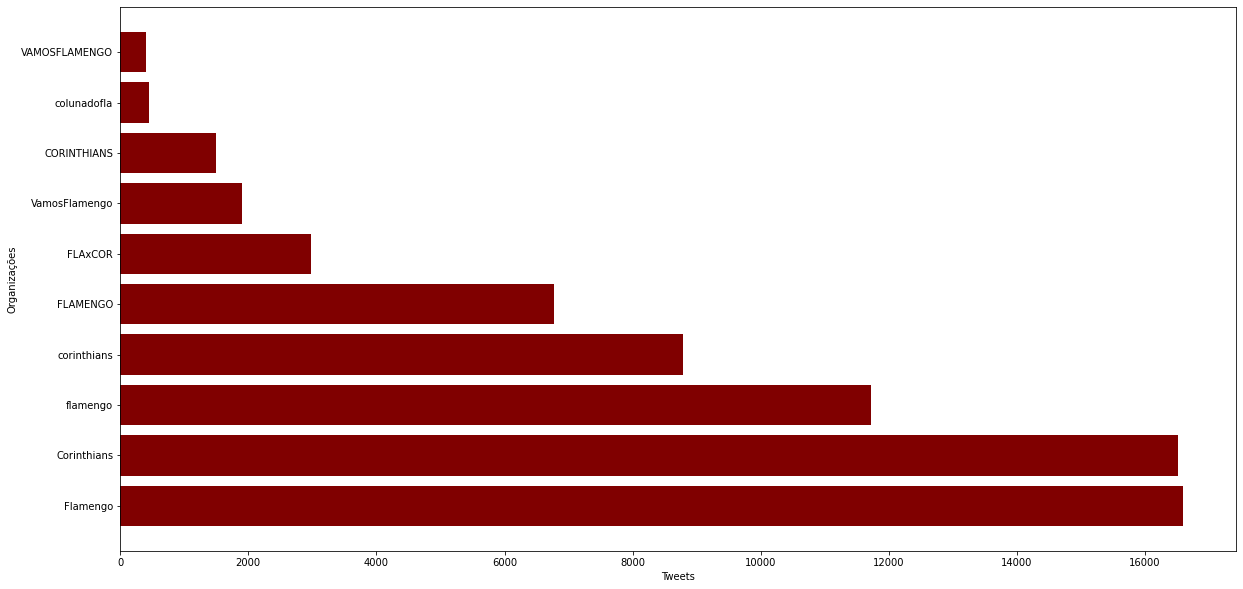

In [12]:
# PEGANDO ENTITIES - ORGANIZATION
palavras_organization = []
for i in jogo1_df.get('entities'):
    if (i.get('annotations') != None):
        for j in i.get('annotations'):
            if(j.get('type') == 'Organization'):
                # print(j.get('normalized_text'))
                palavras_organization.append(j.get('normalized_text'))

from collections import Counter
contador = Counter(palavras_organization)
# for i in contador.items():
#     print(i)
a = {}
print(contador.most_common(10))
for k,v in contador.most_common(10):
    a[k] = v

x = list(a.keys())
y = list(a.values())

fig = plt.figure(figsize=(20, 10))
plt.barh(x, y, color='maroon')
plt.xlabel("Tweets")
plt.ylabel("Organizações")
# plt.title("Cid")
plt.show()

[('Maracanã', 843), ('MARACANÃ', 273), ('Brasil', 213), ('BRASIL', 173), ('MARACA', 113), ('CORINTHIANS', 87), ('brasil', 66), ('RJ', 54), ('São Paulo', 44), ('SP', 41)]


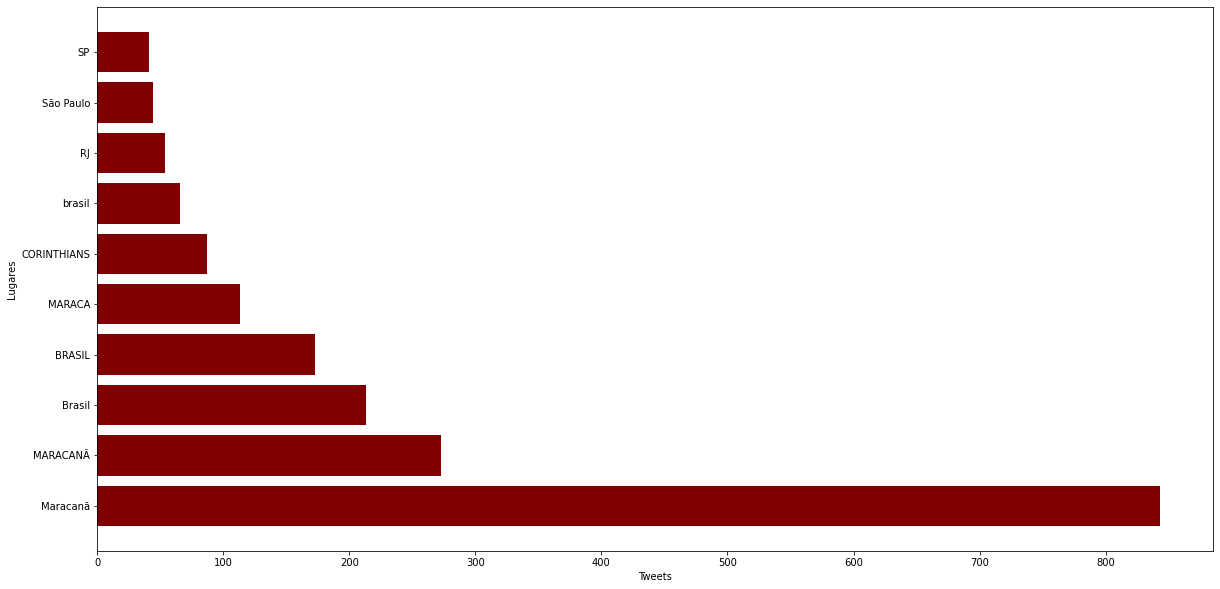

In [13]:
# PEGANDO ENTITIES - PLACE
palavras_place = []
for i in jogo1_df.get('entities'):
    if (i.get('annotations') != None):
        for j in i.get('annotations'):
            if(j.get('type') == 'Place'):
                # print(j.get('normalized_text'))
                palavras_place.append(j.get('normalized_text'))

from collections import Counter
contador = Counter(palavras_place)
# for i in contador.items():
#     print(i)
a = {}
print(contador.most_common(10))
for k,v in contador.most_common(10):
    a[k] = v

x = list(a.keys())
y = list(a.values())

fig = plt.figure(figsize=(20, 10))
plt.barh(x, y, color='maroon')
plt.xlabel("Tweets")
plt.ylabel("Lugares")
# plt.title("Cid")
plt.show()

[('Deus', 926), ('CopaDoBrasil', 823), ('DEUS', 456), ('deus', 442), ('Copa do Brasil', 360), ('FinalCopaDoBrasil', 254), ('CORINTHIANS', 252), ('VaiCorinthians', 204), ('libertadores', 174), ('FLAxCOR', 161), ('CopaDoBrasil2022', 142), ('Copa de Brasil', 94), ('copadobrasil', 72), ('DiaDeCorinthians', 72), ('copa', 60), ('Libertadores', 58), ('AIFOD', 52), ('MercadoPago', 42), ('Copa', 33), ('Copa do Brasil 2022', 31)]


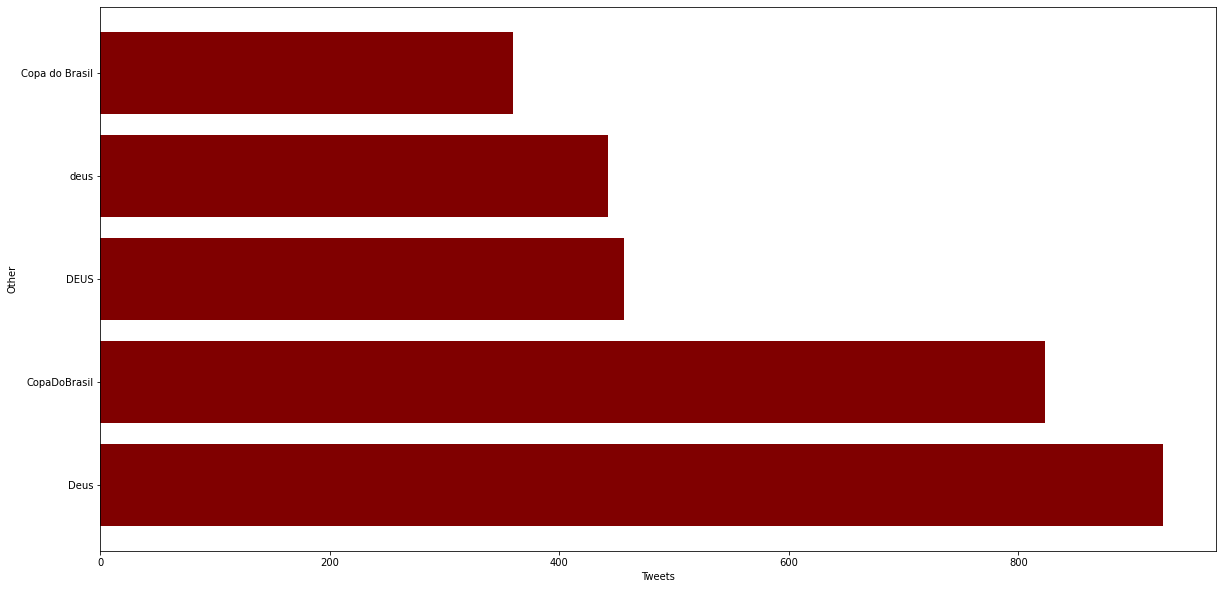

In [15]:
# PEGANDO ENTITIES - OTHERS
palavras_other = []
for i in jogo1_df.get('entities'):
    if (i.get('annotations') != None):
        for j in i.get('annotations'):
            if(j.get('type') == 'Other'):
                # print(j.get('normalized_text'))
                palavras_other.append(j.get('normalized_text'))

from collections import Counter
contador = Counter(palavras_other)
# for i in contador.items():
#     print(i)
a = {}
print(contador.most_common(20))
for k,v in contador.most_common(5):
    a[k] = v

x = list(a.keys())
y = list(a.values())

fig = plt.figure(figsize=(20, 10))
plt.barh(x, y, color='maroon')
plt.xlabel("Tweets")
plt.ylabel("Other")
# plt.title("Cid")
plt.show()

In [13]:
def tokenize(text):
    return text.split()

class LBC:

    booster_words = [
            'muito',
            'super',
    ]

    downtoner_words = [
            'pouco',
            'apenas'
    ]

    negative_words = [
            'não',
            'nem'
    ]

    BOOST_POLARITY = 3

    def __init__(self, sentiment_lexicon_file):
        self.sentiment_lexicon = self.read_lexicon(
                self.liwc_reader, sentiment_lexicon_file)

    def read_lexicon(self, reader, lexicon_file):
        return reader(lexicon_file)

    def liwc_reader(self, lexicon_file):
        sentiment_lex = {}
        posemo = '126'
        negemo = '127'
        words_tags = open(lexicon_file, 'r').readlines()[66:]
        for entry in words_tags:
            w_tags = entry.split('\t')
            word = w_tags[0]
            if word[-1] != '*' \
                    and word not in self.booster_words \
                    and word not in self.downtoner_words \
                    and word not in self.negative_words:
                if posemo in w_tags:
                    sentiment_lex[word] = 1
                elif negemo in w_tags:
                    sentiment_lex[word] = -1
        return sentiment_lex

    def get_polarity(self, word):
        if word in self.sentiment_lexicon:
            return self.sentiment_lexicon[word]
        return 0

    def context_polarity(self, tokens, sent_word_idx):
        negation = False
        booster = False
        downtoner = False
        sentiment_word = tokens[sent_word_idx]
        word_polarity = self.get_polarity(sentiment_word)
        if len(list(set(tokens[:sent_word_idx]) &
                    set(self.negative_words))) > 0:
            negation = True
        if len(list(set(tokens[:sent_word_idx]) &
                    set(self.booster_words))) > 0:
            booster = True
        if len(list(set(tokens[:sent_word_idx]) &
                    set(self.downtoner_words))) > 0:
            downtoner = True
        if negation:
            if downtoner:
                return self.BOOST_POLARITY * word_polarity
            if booster:
                return 1 / self.BOOST_POLARITY * word_polarity
            return -1 * word_polarity
        elif booster:
            return self.BOOST_POLARITY * word_polarity
        elif downtoner:
            return 1 / self.BOOST_POLARITY * word_polarity
        return word_polarity

    def classify(self, text):
        tokens = tokenize(text)
        return sum([self.context_polarity(tokens, idx)
                    for idx in range(len(tokens))])


In [14]:
classifier = LBC('/content/data/MyDrive/coleta/LIWC2007_Portugues_win.dic.txt')
text = 'eu me amo'
result = classifier.classify(text)
print(text + '\t' + str(result))

eu me amo	1


In [15]:
# MONTANDO NUVEM DE PALAVRAS
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('portuguese')

def pre_processamento(texto):
  
    # seleciona apenas letras e coloca todas em minúsculo 
    letras_min =  re.findall(r'\b[A-zÀ-úü]+\b', texto.lower())

    # remove stopwords
    stop = set(stopwords)
    sem_stopwords = [w for w in letras_min if w not in stop]

    # juntando os tokens novamente em formato de texto
    texto_limpo = " ".join(sem_stopwords)

    return texto_limpo

from enelvo.normaliser import Normaliser

# instanciando
norm = Normaliser(tokenizer='readable')

textos = []
# jogo1_df.get('text')
sentiments = []

for i in jogo1_df.get('text'):
    text = re.sub(r'https\S+', '', i)
    text = re.sub(r'RT', '', text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'#\S+', '', text)
    text = re.sub(r'kkk\S+', '', text)
    # text = text.replace('\n', ' ')
    # text = text.lower()
    # text = text.translate(str.maketrans('', '', string.punctuation) )
    # frase = text.strip().split(' ')
    # frase = word_tokenize(text)

    nova_frase = ''
    # print('TEXT:: ' + text)
    if (text != '' or text != ' '):
        try:
            nova_frase = norm.normalise(text)
            text = pre_processamento(nova_frase)
            sentiments.append(str(classifier.classify(text)))
        except:
            print('ERRO')
a = jogo1_df
a['sentiment'] = sentiments
a.head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
ERROR:enelvo.normaliser:Failed to normalise word "kakakaka"!
ERROR:enelvo.normaliser:Failed to normalise word "começçççaaa"!
ERROR:enelvo.normaliser:Failed to normalise word "começçççaaa"!
ERROR:enelvo.normaliser:Failed to normalise word "aaakemkeke"!
ERROR:enelvo.normaliser:Failed to normalise word "putaquepariu"!
ERROR:enelvo.normaliser:Failed to normalise word "começçççaaa"!
ERROR:enelvo.normaliser:Failed to normalise word "ahurpicoli"!
ERROR:enelvo.normaliser:Failed to normalise word "brooklyn"!
ERROR:enelvo.normaliser:Failed to normalise word "vaaammmooosss"!
ERROR:enelvo.normaliser:Failed to normalise word "𝓬𝓸𝓹𝓪"!
ERROR:enelvo.normaliser:Failed to normalise word "começcccooouuu"!
ERROR:enelvo.normaliser:Failed to normalise word "rrrooolllooo"!
ERROR:enelvo.normaliser

,author_id,context_annotations,created_at,entities,geo,possibly_sensitive,text,sentiment
23,154347169,"[{'domain': {'id': '6', 'name': 'Sports Event'...",2022-10-20 00:45:13+00:00,{},{},False,VAAAAAAAMOOOOOOSSSS FLAMENGO,1
10,1538936209615077377,"[{'domain': {'id': '6', 'name': 'Sports Event'...",2022-10-20 00:45:14+00:00,{},{},False,Só se ouve a torcida do Corinthians,0
12,2801046916,"[{'domain': {'id': '6', 'name': 'Sports Event'...",2022-10-20 00:45:15+00:00,{},{},False,"Em nome do pai, do filho e do Espírito Santo, ...",1
18,3400722189,"[{'domain': {'id': '6', 'name': 'Sports Event'...",2022-10-20 00:45:16+00:00,"{'hashtags': [{'start': 14, 'end': 26, 'tag': ...",{},False,Jogai por nós #CORINTHIANS,1
15,775815254370553856,"[{'domain': {'id': '6', 'name': 'Sports Event'...",2022-10-20 00:45:17+00:00,{},{},False,VAI CORINTHIANS,0


In [16]:
positivo = a.query("sentiment > '0'")
neutro = a.query("sentiment == '0' or sentiment == '0.0'")
negativo = a.query("sentiment < '0'")
neutro.count()

author_id              128814
context_annotations    112598
created_at             128814
entities               128814
geo                    128814
possibly_sensitive     128814
text                   128814
sentiment              128814
dtype: int64

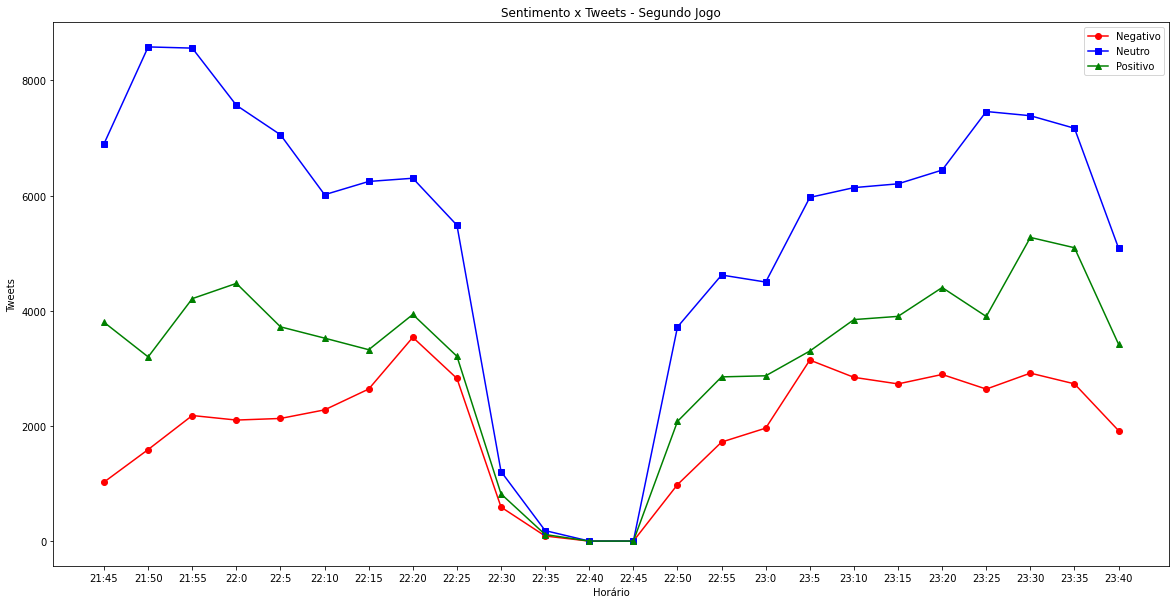

In [17]:
positivo = positivo.sort_values(by=['created_at'])
positivo["created_at"] = positivo["created_at"].map(pd.Timestamp)
df_pos = positivo.groupby(pd.Grouper(key='created_at', axis=0, 
                      freq='5min')).aggregate(func='count')

negativo = negativo.sort_values(by=['created_at'])
negativo["created_at"] = negativo["created_at"].map(pd.Timestamp)
df_neg = negativo.groupby(pd.Grouper(key='created_at', axis=0, 
                      freq='5min')).aggregate(func='count')

neutro = neutro.sort_values(by=['created_at'])
neutro["created_at"] = neutro["created_at"].map(pd.Timestamp)
df_neu = neutro.groupby(pd.Grouper(key='created_at', axis=0, 
                      freq='5min')).aggregate(func='count')

x = []
x_neg = []
x_neu = []
# tempo = []
for i in df_pos.index:
    i = i.astimezone(tz='America/Sao_Paulo')
    x.append(str(i.hour) + ':' + str(i.minute))

for i in df_neg.index:
    i = i.astimezone(tz='America/Sao_Paulo')
    x_neg.append(str(i.hour) + ':' + str(i.minute))

for i in df_neu.index:
    i = i.astimezone(tz='America/Sao_Paulo')
    x_neu.append(str(i.hour) + ':' + str(i.minute))

y = df_pos.get(['author_id'])
y_neg = df_neg.get(['author_id'])
y_neu = df_neu.get(['author_id'])

fig = plt.figure(figsize=(20, 10))
plt.plot(x_neg,y_neg,color='red', label='Negativo', marker='o')
plt.plot(x_neu,y_neu, color='blue', label='Neutro', marker='s')
plt.plot(x,y, color='green', label='Positivo', marker='^')
plt.xlabel("Horário")
plt.ylabel("Tweets")
plt.title("Sentimento x Tweets - Segundo Jogo")
plt.legend()
plt.show()

LANCES IMPORTANTES:

1.   23:28 - gol do corinthians, giuliano
2.   23:06 - gol anulado, everton ribeiro
3.   23:03 - inacreditavel roger guedes
4.   22:58 - chance clara arrascaeta
5.   22:56 - chance clara yuri
6.   22:17 - gol anulado arrascaeta
7.   21:48 - gol do flamengo, pedro

In [7]:
# PEGANDO PESSOAS MAIS CITADAS POR PERIODO
# define a Custom aggregation 
from collections import Counter
# function for finding total
def total(series):
    df = pd.DataFrame(series)
    palavras_person = []
    for i in df.get('entities'):
        if (i.get('annotations') != None):
            for j in i.get('annotations'):
                if(j.get('type') == 'Person'):
                    # print(j.get('normalized_text'))
                    palavras_person.append(j.get('normalized_text'))


    contador = Counter(palavras_person)
    k = 'NINGUÉM'
    v = 0
    if (len(contador.most_common(3)) > 0):
        k1,v1 = contador.most_common(3)[0]
        k2,v2 = contador.most_common(3)[1]
        k3,v3 = contador.most_common(3)[2]
        value = k1 + ',' + k2 + ',' + k3
    return value

teste = jogo1_df.sort_values(by=['created_at'])
teste["created_at"] = teste["created_at"].map(pd.Timestamp)
teste = teste.groupby(pd.Grouper(key='created_at', axis=0, 
                      freq='15min')).aggregate(func=total)
teste

/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)
/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)
/usr/local/lib/python3.7/dist-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)
/usr/lo

,entities
created_at,
2022-10-20 00:45:00+00:00,"Pedro,CORINTHIANS,MENGO"
2022-10-20 01:00:00+00:00,"Pedro,CORINTHIANS,Pedro Guilherme"
2022-10-20 01:15:00+00:00,"CORINTHIANS,Pedro,Arrascaeta"
2022-10-20 01:30:00+00:00,"CORINTHIANS,Renato Augusto,Lucas Piton"
2022-10-20 01:45:00+00:00,"CORINTHIANS,Pedro,Adson"
2022-10-20 02:00:00+00:00,"roger guedes,CORINTHIANS,Roger Guedes"
2022-10-20 02:15:00+00:00,"CORINTHIANS,Dorival,roger guedes"
2022-10-20 02:30:00+00:00,"CORINTHIANS,Dorival,SANGUE"


In [20]:
%matplotlib inline
municipios = geobr.read_municipality(code_muni='all', year=2019)
estados = geobr.read_state(code_state='all', year=2019)

In [21]:
cidades = []
for i in jogo1_df.get('geo'):
    if (i != {}):
        cidades.append(unidecode(i['name'].casefold()))

from collections import Counter
contador = Counter(cidades)
df_mun =pd.DataFrame.from_dict(contador, orient='index').reset_index()

In [24]:
len(cidades)

4805

In [22]:
municipios["name_muni"] = municipios["name_muni"].transform(lambda x: unidecode(x.casefold()))
df_mun.rename(columns = {'index':'mun', 0:'qtd'}, inplace = True)
municipios = municipios.merge(df_mun, how="left", left_on="name_muni", right_on="mun")
df_estados = municipios.groupby(['abbrev_state']).sum()
df_estados.head()

,code_muni,code_state,code_region,qtd
abbrev_state,,,,
AC,2.640772e+07,264.0,22.0,13.0
AL,2.758879e+08,2754.0,204.0,156.0
AM,8.073445e+07,806.0,62.0,86.0
AP,2.560591e+07,256.0,16.0,31.0
BA,1.216452e+09,12093.0,834.0,125.0


/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:33: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in geom:
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:65: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  for t in polygon])
/usr/local/lib/python3.7/dist-packages/descartes/patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


(-76.24758052684999, -26.59070825415, -35.70232894755001, 7.222992030549992)

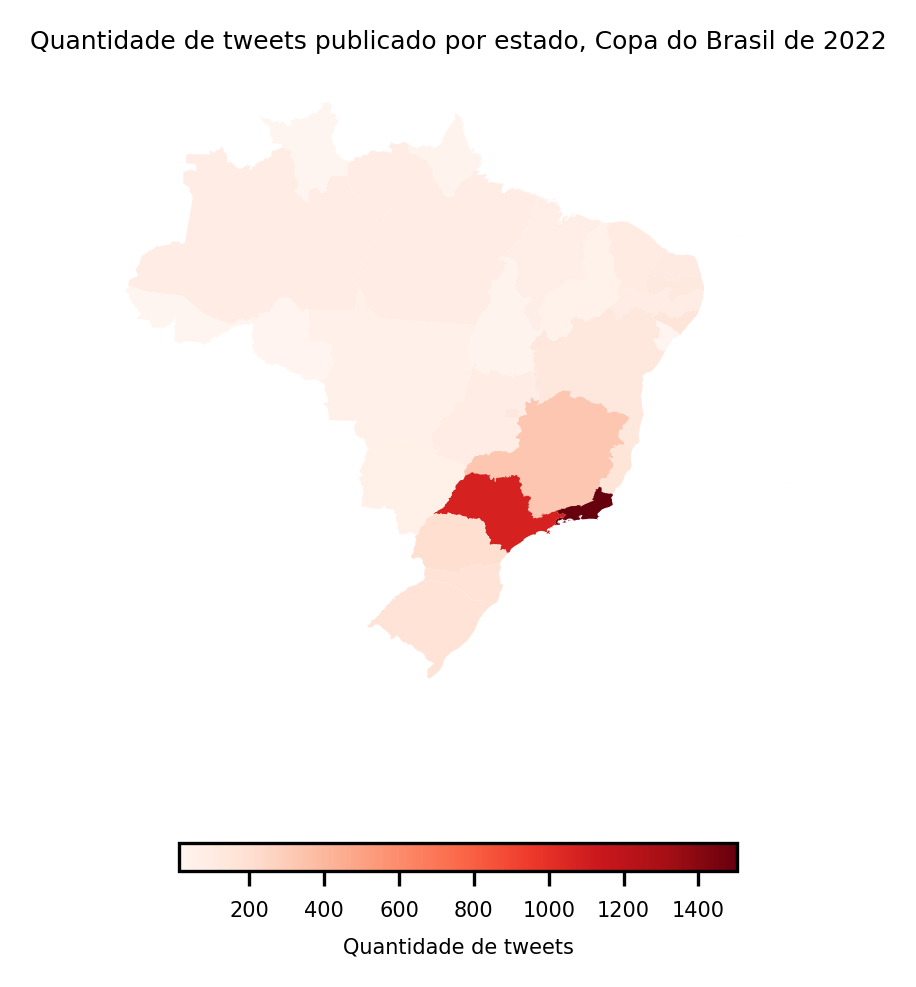

In [23]:
estados = estados.merge(df_estados, how="left", left_on="abbrev_state", right_on="abbrev_state")
plt.rcParams.update({"font.size": 5})

fig, ax = plt.subplots(figsize=(4, 4), dpi=300)

estados.plot(
    column="qtd",
    cmap="Reds",
    legend=True,
    legend_kwds={
        "label": "Quantidade de tweets",
        "orientation": "horizontal",
        "shrink": 0.6,
    },
    ax=ax,
)

ax.set_title("Quantidade de tweets publicado por estado, Copa do Brasil de 2022")
ax.axis("off")